In [1]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from l2_pipeline import L2DatasetLoader

In [2]:
# === Load Data ===
data_dir = "data"
nc_files = glob.glob(os.path.join(data_dir, '**', '*.nc'), recursive=True)
print(f"Found {len(nc_files)} files.")

Found 41 files.


In [3]:
loader = L2DatasetLoader(variable='chlor_a')
datasets = loader.load_multiple(nc_files)

In [4]:
len(datasets)

41

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import cupy as cp
from concurrent.futures import ThreadPoolExecutor

# ========== SETTINGS ==========
datasets_subset = datasets  # Assuming `datasets` is preloaded

# ========== GPU DATA EXTRACTION FUNCTION ==========
def extract_data_gpu(ds):
    # Convert to CuPy for GPU processing
    var = cp.asarray(ds['chlor_a'].values).flatten()
    lat = cp.asarray(ds['lat'].values).flatten()
    lon = cp.asarray(ds['lon'].values).flatten()

    # Mask NaNs on GPU
    mask = ~cp.isnan(var) & ~cp.isnan(lat) & ~cp.isnan(lon)

    # Filter and convert back to NumPy for plotting
    return (
        cp.asnumpy(lon[mask]),
        cp.asnumpy(lat[mask]),
        cp.asnumpy(var[mask])
    )

# ========== RUN EXTRACTION IN PARALLEL ==========
with ThreadPoolExecutor() as executor:
    results = list(executor.map(extract_data_gpu, datasets_subset))

# ========== CONCATENATE ALL GPU-PROCESSED RESULTS ==========
all_lon = np.concatenate([r[0] for r in results])
all_lat = np.concatenate([r[1] for r in results])
all_var = np.concatenate([r[2] for r in results])

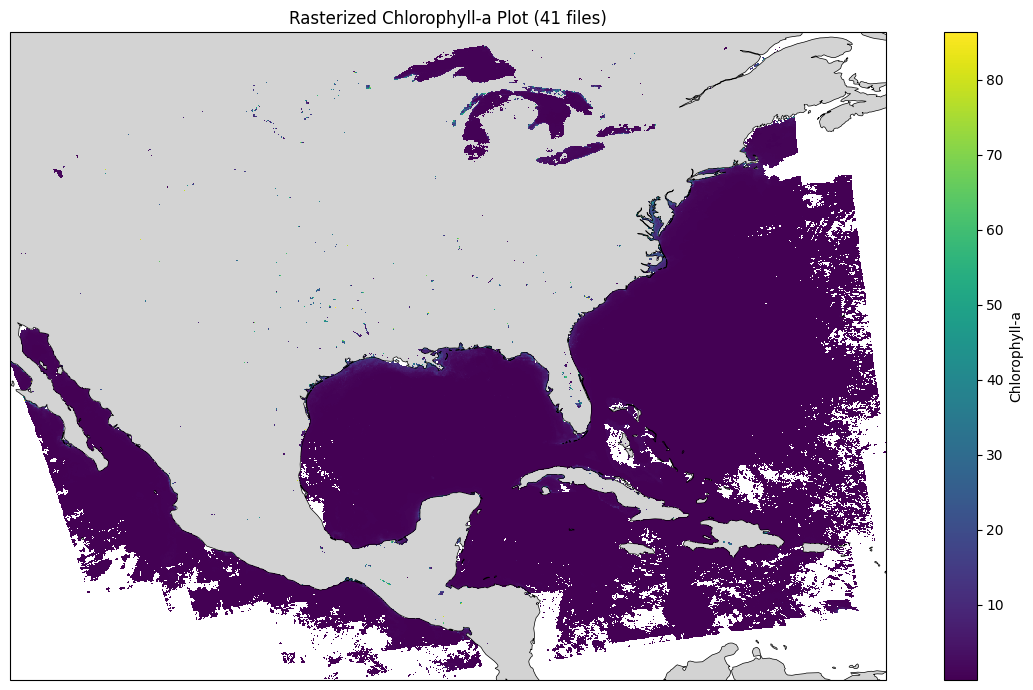

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
import numpy as np

lat_bins, lon_bins = 1000, 1000

# Create 2D histogram for chlor_a using binning
stat, lat_edges, lon_edges, _ = binned_statistic_2d(
    all_lat, all_lon, all_var, statistic='mean', bins=[lat_bins, lon_bins]
)

# Meshgrid needed for pcolormesh (edges, not centers)
lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)

# ========== PLOTTING ==========
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot raster using pcolormesh
raster = ax.pcolormesh(lon_grid, lat_grid, stat, cmap='viridis', shading='auto', transform=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Colorbar and title
plt.colorbar(raster, label='Chlorophyll-a')
plt.title(f"Rasterized Chlorophyll-a Plot ({len(datasets_subset)} files)")
plt.tight_layout()
plt.show()


In [ ]:
# ========== PLOTTING ==========
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

sc = ax.scatter(all_lon, all_lat, c=all_var, cmap='viridis', s=0.5, alpha=0.5, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
plt.colorbar(sc, label='Chlorophyll-a')
plt.title(f"GPU-Accelerated Chlorophyll-a Plot")
plt.tight_layout()
plt.show()

In [ ]:
# === Plot Single Example ===
ds = datasets[0]
var = ds['chlor_a'].values.flatten()
lat = ds['lat'].values.flatten()
lon = ds['lon'].values.flatten()

mask = (var != np.nan) & (lat != np.nan) & (lon != np.nan)

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

sc = ax.scatter(lon[mask], lat[mask], c=var[mask], cmap='viridis', s=1, transform=ccrs.PlateCarree())
plt.colorbar(sc, label='Chlorophyll-a')
plt.title("Single File: Chlorophyll-a")
plt.tight_layout()
plt.show()

In [ ]:
import xarray as xr

ds = xr.open_dataset("data/Mississippi_2021-06-21_2021-07-21/AQUA_MODIS.20210630T182501.L2.OC.nc", group='navigation_data')
print(ds)